<a href="https://colab.research.google.com/github/enakai00/colab_GenAI_lecture/blob/main/05_VAE_with_label_trick_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20230629)

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, losses

from tensorflow.keras.datasets import fashion_mnist

np.random.seed(20230629)
tf.random.set_seed(20230629)

In [2]:
(train_images, train_labels), _ = fashion_mnist.load_data()
train_images = np.pad(train_images, ((0, 0), (2, 2), (2, 2)), constant_values=0)
train_images = train_images.reshape((len(train_images), 32*32)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
def create_labeled_image(x):
    image, label = x
    return np.append(image, label).tolist()

In [5]:
labeled_images = map(create_labeled_image, zip(train_images, train_labels))
labeled_images = np.array(list(labeled_images)).astype('float32')

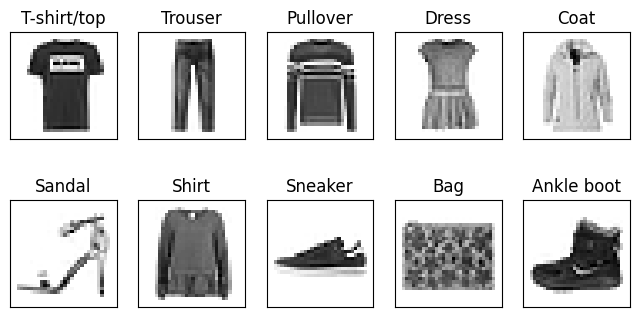

In [6]:
sample_indices = []
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(10):
    for c, (image, label) in enumerate(zip(train_images, train_labels)):
        if np.argmax(label) == i:
            sample_indices.append(c)
            break

fig = plt.figure(figsize=(8, 4))
for i in range(10):
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title(labels[i])
    subplot.imshow(labeled_images[sample_indices[i]][:32*32].reshape((32, 32)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

In [10]:
encoder = models.Sequential()
encoder.add(layers.Lambda(lambda x: x[:, :32*32], name='drop_label', input_shape=(32*32+10,)))
encoder.add(layers.Reshape((32, 32, 1), name='reshape'))
encoder.add(layers.Conv2D(32, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_filter1')) # (16, 16, 32)
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_filter2')) # (8, 8, 64)
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_filter3')) # (4, 4, 128)
encoder.add(layers.Flatten(name='flatten'))
encoder.add(layers.Dense(4, name='mean_and_log_var'))

encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 drop_label (Lambda)         (None, 1024)              0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 1)         0         
                                                                 
 conv_filter1 (Conv2D)       (None, 16, 16, 32)        320       
                                                                 
 conv_filter2 (Conv2D)       (None, 8, 8, 64)          18496     
                                                                 
 conv_filter3 (Conv2D)       (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 mean_and_log_var (Dense)    (None, 4)                

In [11]:
sampler = models.Sequential()
sampler.add(layers.Lambda(
    lambda x: x[:, 0:2] + tf.exp(0.5 * x[:, 2:4]) * K.random_normal(shape=(tf.shape(x)[0], 2)),
    input_shape=(4,), name='sampled_embedding'))

sampler.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sampled_embedding (Lambda)  (None, 2)                 0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [13]:
decoder = models.Sequential()
decoder.add(layers.Dense(4 * 4 * 128, input_shape=(2+10, ), name='expand'))
decoder.add(layers.Reshape((4, 4, 128), name='reshape2'))
decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_transpose1')) # (8, 8, 64)
decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_transpose2')) # (16, 16, 32)
decoder.add(layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same',
                        activation='sigmoid', name='conv_transpose3')) # (32, 32, 1)
decoder.add(layers.Flatten(name='flatten'))

decoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 expand (Dense)              (None, 2048)              26624     
                                                                 
 reshape2 (Reshape)          (None, 4, 4, 128)         0         
                                                                 
 conv_transpose1 (Conv2DTran  (None, 8, 8, 64)         73792     
 spose)                                                          
                                                                 
 conv_transpose2 (Conv2DTran  (None, 16, 16, 32)       18464     
 spose)                                                          
                                                                 
 conv_transpose3 (Conv2DTran  (None, 32, 32, 1)        289       
 spose)                                                          
                                                      

In [17]:
model_input = tf.keras.Input(shape=(32*32+10,))
model_output = layers.Concatenate(name='prediction_with_mean_log_var')(
    [encoder(model_input),
     decoder(tf.concat(
          (sampler(encoder(model_input)), model_input[:, 32*32:]), axis=1) # Provide label to the decoder
     )
    ]
)

model = models.Model(model_input, model_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1034)]       0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 4)            100868      ['input_5[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 sequential_3 (Sequential)      (None, 2)            0           ['sequential_2[8][0]']           
                                                                                                  
 tf.__operators__.getitem_3 (Sl  (None, 10)          0           ['input_5[0][0]']            

In [18]:
def custom_loss(y_true, y_pred):
    mean, log_var, pred = y_pred[:, 0:2], y_pred[:, 2:4], y_pred[:, 4:]
    reconstruction_loss = losses.mse(pred, y_true)
    kl_loss = tf.reduce_mean(tf.reduce_sum(
        -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var)), axis=1))
    loss = reconstruction_loss + 0.001* kl_loss
    return loss

In [19]:
model.compile(optimizer='adam', loss=custom_loss)

In [20]:
def show_result():
    results = model.predict(labeled_images[sample_indices], verbose=0)[:, 4:]

    fig = plt.figure(figsize=(16, 2.7))
    for i in range(10):
        subplot = fig.add_subplot(2, 10, i+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(train_images[sample_indices[i]].reshape((32, 32)),
                       vmin=0, vmax=1, cmap=plt.cm.gray_r)

        subplot = fig.add_subplot(2, 10, i+11)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(results[i].reshape((32, 32)),
                       vmin=0, vmax=1, cmap=plt.cm.gray_r)

300/300 [==============================] - 15s 8ms/step - loss: 0.0547


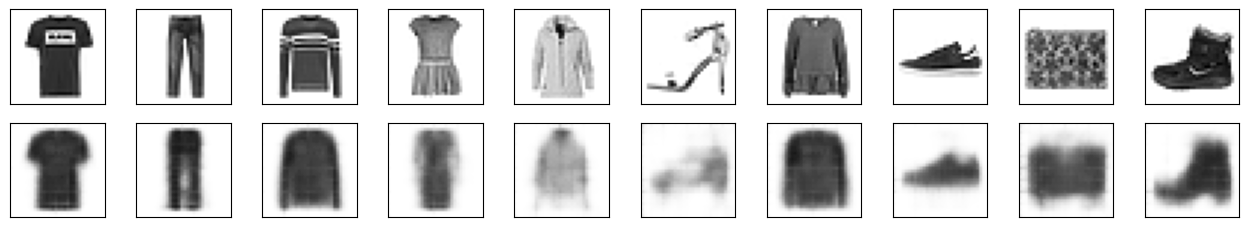

In [21]:
history = model.fit(labeled_images[:30000], train_images[:30000],
                    batch_size=100, epochs=1)
show_result()

Epoch 1/50
600/600 [==============================] - 4s 7ms/step - loss: 0.0281
Epoch 2/50
600/600 [==============================] - 4s 7ms/step - loss: 0.0263
Epoch 3/50
600/600 [==============================] - 4s 7ms/step - loss: 0.0257
Epoch 4/50
600/600 [==============================] - 4s 7ms/step - loss: 0.0253
Epoch 5/50
600/600 [==============================] - 4s 7ms/step - loss: 0.0251
Epoch 6/50
600/600 [==============================] - 4s 7ms/step - loss: 0.0249
Epoch 7/50
600/600 [==============================] - 4s 7ms/step - loss: 0.0247
Epoch 8/50
600/600 [==============================] - 4s 7ms/step - loss: 0.0246
Epoch 9/50
600/600 [==============================] - 4s 7ms/step - loss: 0.0245
Epoch 10/50
600/600 [==============================] - 4s 7ms/step - loss: 0.0244
Epoch 11/50
600/600 [==============================] - 4s 7ms/step - loss: 0.0243
Epoch 12/50
600/600 [==============================] - 4s 7ms/step - loss: 0.0242
Epoch 13/50
600/600 [====

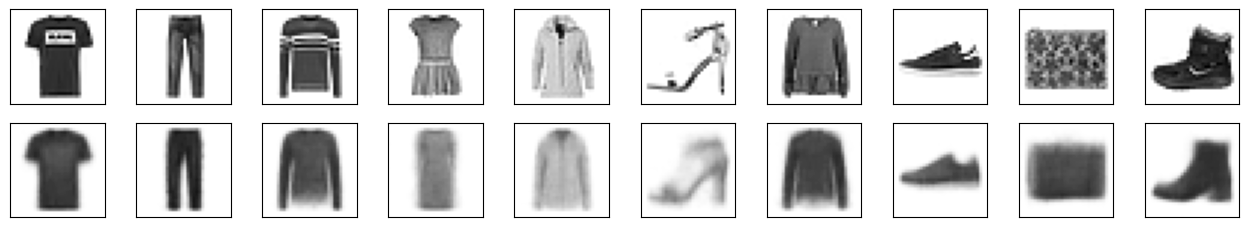

In [22]:
history = model.fit(labeled_images, train_images,
                    batch_size=100, epochs=50)
show_result()

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [24]:
encoder.save('/content/gdrive/My Drive/var_encoder_label_trick.hd5', save_format='h5')
decoder.save('/content/gdrive/My Drive/var_decoder_label_trick.hd5', save_format='h5')

In [25]:
!ls -lh '/content/gdrive/My Drive/var_encoder_label_trick.hd5'
!ls -lh '/content/gdrive/My Drive/var_decoder_label_trick.hd5'

-rw------- 1 root root 415K Jun 30 13:40 '/content/gdrive/My Drive/var_encoder_label_trick.hd5'
-rw------- 1 root root 487K Jun 30 13:40 '/content/gdrive/My Drive/var_decoder_label_trick.hd5'
